In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pyhash
import matplotlib.pyplot as plt

### Data Preprocessing

In [2]:
df = pd.read_csv("train.data", sep=" ", header=None, usecols=[1,2])

In [3]:
stream = df.to_numpy()

In [4]:
np.random.seed(42)

### MisraGries Class 

In [5]:
class MisraGries():
    def __init__(self, k):
        self.counters = {}
        self.k = k
        
    def process(self, element, count):
        if element in self.counters.keys():
            self.counters[element] += count
        else:
            if len(self.counters.keys()) < self.k-1:
                self.counters[element] = count
            else:
                self.counters = {x:y-count for x, y in self.counters.items()}
                in_count = max(0, -1*min(self.counters.values()))
                self.counters = {x:y+in_count for x, y in self.counters.items() if y+in_count>0}
                if in_count>0:                    
                    self.counters[element] = in_count
                           
    def query(self, q):
#         print(self.counters)
        if q in self.counters.keys():
            return self.counters[q]
        return 0
                

In [5]:
# ct_mg = MisraGries(100)

In [6]:
# for i in tqdm(range(stream.shape[0])):
#     ct_mg.process(stream[i][0], stream[i][1])

100%|██████████| 1467345/1467345 [00:03<00:00, 400501.97it/s]


In [7]:
# ct_mg.query(12)

39611

### Count Min Class

In [6]:
class CountMin():
    def __init__(self, w, d):
        self.w = w
        self.d = d
        self.hasher = [pyhash.super_fast_hash(i) for i in range(w)]
        self.counters = np.zeros((w, d))
        
    def process(self, element, count):
        for i in range(self.w):
            self.counters[i, self.hasher[i](str(element))%self.d] += count
    
    def query(self, q):
        return min([self.counters[i, self.hasher[i](str(q))%self.d] for i in range(self.w)])

In [7]:
# ct_cm = CountMin(5, 20)

In [10]:
# for i in tqdm(range(stream.shape[0])):
#     ct_cm.process(stream[i][0], stream[i][1])

100%|██████████| 1467345/1467345 [00:13<00:00, 107748.37it/s]


In [11]:
# ct_cm.query(12)

169183.0

### Count Sketch Class

In [7]:
class CountSketch():
    def __init__(self, w, d):
        self.w = w
        self.d = d
        self.hasher_h = [pyhash.super_fast_hash(i) for i in range(w)]
        self.hasher_g = [pyhash.spooky_32(i) for i in range(w)]
        self.counters = np.zeros((w, d))
        
    def process(self, element, count):
        for i in range(self.w):
            self.counters[i, self.hasher_h[i](str(element))%self.d] += count*(self.hasher_g[i](str(element))%2)
    
    def query(self, q):
        return np.median([self.counters[i, self.hasher_h[i](str(q))%self.d]*(self.hasher_g[i](str(q))%2) for i in range(self.w)])

In [22]:
# ct_cs = CountSketch(5, 20)

In [23]:
# for i in tqdm(range(stream.shape[0])):
#     ct_cs.process(stream[i][0], stream[i][1])

100%|██████████| 1467345/1467345 [00:24<00:00, 60704.15it/s]


In [24]:
# ct_cs.query(12)

90892.0

### Preparing the query data

In [8]:
# Stores the exact frequencies of each item occuring in the stream
exact_freqs = {}

In [9]:
for i in tqdm(range(stream.shape[0])):
    try:
        exact_freqs[stream[i][0]] += stream[i][1]
    except:
        exact_freqs[stream[i][0]] = stream[i][1]

100%|██████████| 1467345/1467345 [00:01<00:00, 953189.20it/s]


In [11]:
arr = np.arange(1000)
np.random.shuffle(arr)
arr = np.sort(arr[:100])

In [12]:
queries = []

In [13]:
ind = 0
for w in sorted(exact_freqs, key=exact_freqs.get, reverse=True):
    if ind in arr:
        queries.append(w)
    ind += 1
queries = np.array(queries)

### Testing predictions for MisraGries, Count Min and Count Sketch

> MisraGries Predictions

In [14]:
mg_error_list = []

k = [100, 200, 500, 1000, 2000]
for j in k:
    rel_error = 0
    ct_mg = MisraGries(j)

    for i in tqdm(range(stream.shape[0])):
        ct_mg.process(stream[i][0], stream[i][1])

    for i in range(100):
        rel_error += (exact_freqs[queries[i]] - ct_mg.query(queries[i]))/exact_freqs[queries[i]]

    rel_error/=100
    mg_error_list.append(rel_error)
    

100%|██████████| 1467345/1467345 [00:02<00:00, 520652.98it/s]


In [27]:
mg_error_list

[0.9992373551708121,
 0.9925474912631737,
 0.9447790103113922,
 0.8706427837802916,
 0.7246504375298524]

> Count Min Predictions

In [15]:
cm_error_list = []

k = [100, 200, 500, 1000, 2000]
for j in k:
    rel_error = 0
    ct_cm = CountMin(5, j//5)

    for i in tqdm(range(stream.shape[0])):
        ct_cm.process(stream[i][0], stream[i][1])

    for i in range(100):
        rel_error += abs(exact_freqs[queries[i]] - ct_cm.query(queries[i]))/exact_freqs[queries[i]]

    rel_error/=100
    cm_error_list.append(rel_error)
    

100%|██████████| 1467345/1467345 [00:13<00:00, 105698.62it/s]


In [16]:
cm_error_list

[150.8331555703926,
 67.19078414509968,
 21.767250022146783,
 9.312634925952935,
 3.985883454903427]

> Count Sketch Predictions

In [17]:
cs_error_list = []

k = [100, 200, 500, 1000, 2000]
for j in k:
    rel_error = 0
    ct_cs = CountSketch(5, j//5)

    for i in tqdm(range(stream.shape[0])):
        ct_cs.process(stream[i][0], stream[i][1])

    for i in range(100):
        rel_error += abs(exact_freqs[queries[i]] - ct_cs.query(queries[i]))/exact_freqs[queries[i]]

    rel_error/=100
    cs_error_list.append(rel_error)
    

100%|██████████| 1467345/1467345 [00:27<00:00, 53246.51it/s]


In [18]:
cs_error_list

[36.613779367106766,
 16.956027524056957,
 6.223144922249254,
 2.818454862108778,
 1.5672015542027404]

In [19]:
error_rates = pd.DataFrame(np.c_[k, mg_error_list, cm_error_list, cs_error_list], columns=["k", "Misra Gries", "Count Min", "Count Sketch"])

### Error rates for the three models

In [20]:
error_rates

,k,Misra Gries,Count Min,Count Sketch
0,100.0,0.999237,150.833156,36.613779
1,200.0,0.992547,67.190784,16.956028
2,500.0,0.944779,21.767250,6.223145
3,1000.0,0.870643,9.312635,2.818455
4,2000.0,0.724650,3.985883,1.567202


### Plot for the error rates

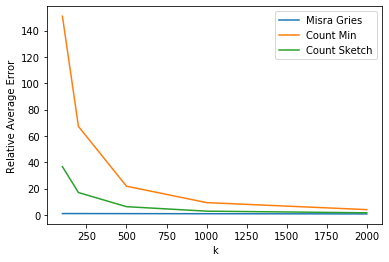

In [21]:
plt.plot(k, mg_error_list, label="Misra Gries")
plt.plot(k, cm_error_list, label="Count Min")
plt.plot(k, cs_error_list, label="Count Sketch")
plt.xlabel("k")
plt.ylabel("Relative Average Error")
plt.legend()

### Minimum D such that Relative Average Error is less than 1

    We observe that, Count Min Sketch achieves less than 1 relative average error at around d = 6000/5 = 1200.
    The Count Sketch on the other hand, achieves less than 1 relative average error at around d = 4000/5 = 800
    
    Hence, we see that on this dataset, count sketch gives better predictions than count min sketch

In [22]:
cm_error_list_min_k = []

k = [2000, 3000, 4000, 5000, 6000]
for j in k:
    rel_error = 0
    ct_cm = CountMin(5, j//5)

    for i in tqdm(range(stream.shape[0])):
        ct_cm.process(stream[i][0], stream[i][1])

    for i in range(100):
        rel_error += abs(exact_freqs[queries[i]] - ct_cm.query(queries[i]))/exact_freqs[queries[i]]

    rel_error/=100
    cm_error_list_min_k.append(rel_error)

100%|██████████| 1467345/1467345 [00:14<00:00, 98699.00it/s] 


In [23]:
cm_error_list_min_k

[3.985883454903427,
 2.3473498096215946,
 1.5618416294440107,
 1.164880599753372,
 0.9194576076057601]

In [25]:
cs_error_list_min_k = []

k = [2000, 3000, 4000, 5000, 6000]
for j in k:
    rel_error = 0
    ct_cs = CountSketch(5, j//5)

    for i in tqdm(range(stream.shape[0])):
        ct_cs.process(stream[i][0], stream[i][1])

    for i in range(100):
        rel_error += abs(exact_freqs[queries[i]] - ct_cs.query(queries[i]))/exact_freqs[queries[i]]

    rel_error/=100
    cs_error_list_min_k.append(rel_error)

100%|██████████| 1467345/1467345 [00:27<00:00, 52607.35it/s]


In [26]:
cs_error_list_min_k

[1.5672015542027404,
 1.1942130718593322,
 0.9568054040181915,
 0.8492505071931566,
 0.7823057389636116]